In [27]:
# Import Keras and verify that the TensorFlow backend is set as the default.
import keras
keras.__version__

'2.1.6'

# Notebook 1

## Classifying newswires: a multi-class classification example

This notebook contains code samples that have been adapted from Francois Chollet's Deep Learning With Python.

----
In this notebook we are going to introduce how to build a [`Sequential`](https://keras.io/getting-started/sequential-model-guide/) model using [`Dense`](https://keras.io/layers/core/) layers. A Sequential model is a linear stack of layers with a single input and output. A Dense layer is a fully connected layer in your model. We are also going to introduce the following APIs:
* `compile`
* `fit`
* `evaluate`
* `predict`

We will also introduce `callbacks` and how you can use them as part of model training. 

## Problem
To get familiar with Keras APIs we we going to build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification".

## Dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

A number of datasets come packaged as part of Keras. A few examples of these Datasets can be found [here](https://keras.io/datasets/). Some example datasets are IMDB, MNIST, CIFAR10 etc. The _Reuters dataset_ also comes prepackaged with Keras. Lets take a look at what the data looks like.

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 12s 6us/step


The argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

Each example is a list of integers (word indices):

In [4]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 5s 9us/step


In [6]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Since we limit the number of word index dictionary to the first 10000 words, there is a chance
that the newswire will have words that do not have an index associated with it. This is what the ? symbol
represents in the above newswire.

The label associated with an example is an integer between 0 and 45: a topic index.

In [7]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [9]:
x_train[0][:10]

array([ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.])


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index. You can do this using a built-in Keras function:

In [10]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


In this topic classification problem we are trying to classify short snippets of text. The difference between a binary classification problem and this one is that the number of output class is 46 i.e the dimensionality of the output space is much larger. (A binary classification problem is one in which there are two possible output clases.)

## Build a Sequential model:

In [11]:
from keras import models
from keras import layers

# Instantiate a Sequential Model
model = models.Sequential()
# Add 2 Dense layers of 64 units each to the model. Let `relu` be the activation function.
# Note: Specify the input_shape argument for the first layer.
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
# Add a final Dense layer that classifies the output
# Note: You should use 46 units since out output dimension is going to be the number of output classes). 
# Let `softmax` be the activation function.
model.add(layers.Dense(46, activation='softmax'))

Some things to note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* We are using the Relu function for activation.
* The last layer uses a `softmax` activation. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.



## Compile the model:

Compiling the model is "freezing" the model with certain attributes set such as `loss`, `optimizer`, `metrics` etc. 

In [12]:
# Compile the model with a "rmsprop" optimizer, "categorical_crossentropy" loss and "accuracy" \
# metric.
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In Keras you can specify the different parameters above as strings such as "rmsprop" or as keras.optimizers.RMSprop. You can do the same for loss and metrics. Here are a list of [optimizers](https://keras.io/optimizers/), [loss functions](https://keras.io/losses/) and [metrics](https://keras.io/metrics/) that are available in Keras. 

In our example above the best loss function to use `categorical_crossentropy` since it measures the distance between 
the probability distribution output by our network and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

Another point to note is if we had used output labels as integer tensors instead of one-hot encoded vectors, then we should use`sparse_categorical_crossentropy` instead of `categorical_crossentropy`.

## Training our model

Let's set apart 1,000 samples in our training data to use as a validation set:

In [28]:
# Split the training data into train and validation datasets.
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## Now let's train our network for 20 epochs:

In [30]:
# Use the `fit` call with the above training and validation datasets. 
# Use can use a batch size of 512.
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 89us/step - loss: 0.0741 - acc: 0.9578 - val_loss: 1.4263 - val_acc: 0.7840
Epoch 2/20
7982/7982 [==============================] - 1s 88us/step - loss: 0.0726 - acc: 0.9603 - val_loss: 1.4378 - val_acc: 0.7820
Epoch 3/20
7982/7982 [==============================] - 1s 89us/step - loss: 0.0737 - acc: 0.9578 - val_loss: 1.4624 - val_acc: 0.7770
Epoch 4/20
7982/7982 [==============================] - 1s 89us/step - loss: 0.0716 - acc: 0.9583 - val_loss: 1.4730 - val_acc: 0.7750
Epoch 5/20
7982/7982 [==============================] - 1s 90us/step - loss: 0.0714 - acc: 0.9609 - val_loss: 1.5280 - val_acc: 0.7770
Epoch 6/20
7982/7982 [==============================] - 1s 90us/step - loss: 0.0712 - acc: 0.9597 - val_loss: 1.5399 - val_acc: 0.7660
Epoch 7/20
7982/7982 [==============================] - 1s 90us/step - loss: 0.0721 - acc: 0.9583 - val_loss: 1.4768 - val_acc: 0.7790
Epoch 8

Let's display its loss and accuracy curves:

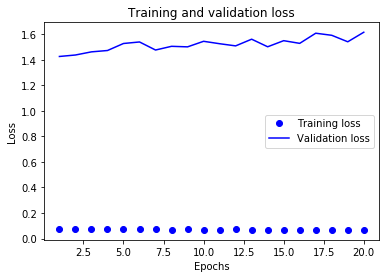

In [31]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

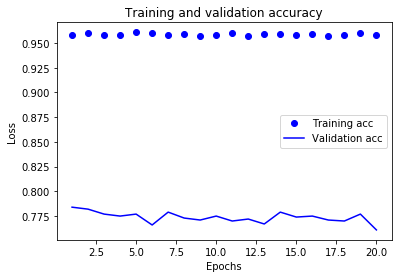

In [32]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. 

## Let's train a new network from scratch for 8 epochs, then let's evaluate it on the test set:

In [33]:
# Use the same model from before and train the model as before. 
# However for this run let the number of epochs be 8.
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=8,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 110us/step - loss: 2.6295 - acc: 0.5199 - val_loss: 1.7297 - val_acc: 0.6520
Epoch 2/8
7982/7982 [==============================] - 1s 88us/step - loss: 1.4180 - acc: 0.7010 - val_loss: 1.2797 - val_acc: 0.7160
Epoch 3/8
7982/7982 [==============================] - 1s 87us/step - loss: 1.0405 - acc: 0.7759 - val_loss: 1.1327 - val_acc: 0.7480
Epoch 4/8
7982/7982 [==============================] - 1s 88us/step - loss: 0.8151 - acc: 0.8282 - val_loss: 1.0313 - val_acc: 0.7740
Epoch 5/8
7982/7982 [==============================] - 1s 88us/step - loss: 0.6458 - acc: 0.8633 - val_loss: 0.9390 - val_acc: 0.8010
Epoch 6/8
7982/7982 [==============================] - 1s 88us/step - loss: 0.5122 - acc: 0.8924 - val_loss: 0.9040 - val_acc: 0.8170
Epoch 7/8
7982/7982 [==============================] - 1s 89us/step - loss: 0.4116 - acc: 0.9131 - val_loss: 0.8878 - val_acc: 0.8110
Epoch 8/8
798

## Evaluate the model:

In [34]:
# Use `evaluate` the model with the test training input(x_test) and 
# the one-hot encoded labels(one_hot_test_labels).
results = model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 116us/step



Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [35]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1861086375779163

## Exercise 1: Now let us try with a larger network with 128 Dense units:

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 161us/step - loss: 2.1474 - acc: 0.5600 - val_loss: 1.3717 - val_acc: 0.6890
Epoch 2/20
7982/7982 [==============================] - 1s 129us/step - loss: 1.1111 - acc: 0.7544 - val_loss: 1.0968 - val_acc: 0.7730
Epoch 3/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.7735 - acc: 0.8317 - val_loss: 1.0010 - val_acc: 0.7890
Epoch 4/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.5702 - acc: 0.8757 - val_loss: 0.9006 - val_acc: 0.8170
Epoch 5/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.4114 - acc: 0.9132 - val_loss: 0.8740 - val_acc: 0.8200
Epoch 6/20
7982/7982 [==============================] - 1s 130us/step - loss: 0.3162 - acc: 0.9323 - val_loss: 0.9074 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 1s 140us/step - loss: 0.2459 - acc: 0.9434 - val_loss: 0.8669 - val_acc: 0.8170


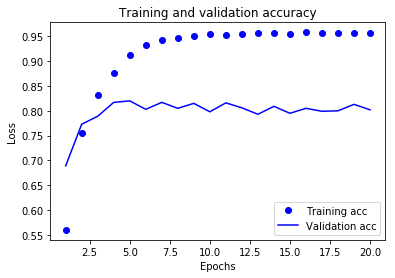

In [49]:
# Use the same model as before but with 128 units set for the first two Dense layers. `compile`, `fit` and `evaluate`
# the model as before. You can also plot the loss and accuracy to see the behavior of the model.

from keras import models
from keras import layers

# Define your model here
# ...
# Exercise 1: Solution
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, with the larger network we get a slight increase in accuracy but the network seems to perform just as good previously.

## Exercise 2: Now let us train the model with a single Dense layer network:

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 122us/step - loss: 3.7771 - acc: 0.0749 - val_loss: 3.7295 - val_acc: 0.0780
Epoch 2/20
7982/7982 [==============================] - 1s 87us/step - loss: 3.6916 - acc: 0.0687 - val_loss: 3.6520 - val_acc: 0.0760
Epoch 3/20
7982/7982 [==============================] - 1s 85us/step - loss: 3.6090 - acc: 0.0707 - val_loss: 3.5692 - val_acc: 0.0610
Epoch 4/20
7982/7982 [==============================] - 1s 86us/step - loss: 3.5197 - acc: 0.0618 - val_loss: 3.4786 - val_acc: 0.0600
Epoch 5/20
7982/7982 [==============================] - 1s 87us/step - loss: 3.4241 - acc: 0.0618 - val_loss: 3.3826 - val_acc: 0.0600
Epoch 6/20
7982/7982 [==============================] - 1s 86us/step - loss: 3.3232 - acc: 0.0626 - val_loss: 3.2813 - val_acc: 0.0610
Epoch 7/20
7982/7982 [==============================] - 1s 88us/step - loss: 3.2185 - acc: 0.0970 - val_loss: 3.1760 - val_acc: 0.3200
Epoch 

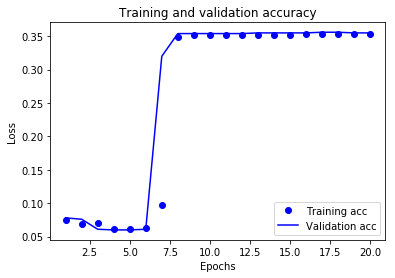

In [50]:
# Use the same model as before but with 1 units set for a single Dense layer. `compile`, `fit` and `evaluate`
# the model as before. You can also plot the loss and accuracy to see the behavior of the model.

from keras import models
from keras import layers

# Define your model here
# ...
# Exercise 2: Solution
model = models.Sequential()
model.add(layers.Dense(1, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

You can see that the accuracy stagnates at around 35% since the network is unable to learn any new information from
the data.

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [38]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

In [39]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [40]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

In [41]:
np.argmax(predictions[0])

3

## Dealing with overfitting:

Common ways to deal with overfitting is to train the model on more data or even to reduce the capacity of the network.
A bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss). Other techniques to deal with overfitting is using weight regularization and dropout. Keras provides APIs that make it very simple to use these techniques. 

### Adding weight regularization:
A common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.
In Keras, [weight regularization](https://keras.io/regularizers/) is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization to an example Dense layer:

In [45]:
mock_dense_layer = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,))

NameError: name 'regularizers' is not defined

### Adding dropout:
[Dropout](https://keras.io/layers/core/), applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [47]:
# An example Dropout layer:
#...
mock_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
mock_model.add(layers.Dropout(0.5)) # 0.5 is the dropout rate
#...

NameError: name 'mock_model' is not defined

## Callbacks
You can use Keras built-in [callbacks](https://keras.io/callbacks/) to checkpoint your model, save TensorBoard summaries, adjust learning rate during training etc.
Callbacks are a way to perform an action, view internal state or model statistics at the beginning/end of the training loop, an epoch or a step in the fit loop.
Let's instantiate the ModelCheckpoint and TensorBoard callback:

# Exercise 3: Create a ModelCheckpoint and TensorBoard callback.

In [52]:
from keras import callbacks
# Create a ModelCheckpoint callback by specifying a filepath such a s'/tmp/checkpoints'. You can look at some of the
# other parameters that you can set in the link above.
# ...

# Create a ModelCheckpoint callback
# model_checkpoint_cb = 

# Create a TensorBoard callback that writes model summaries to a given directory such as '/tmp/logs'.
# tensorboard_cb = 

model_checkpoint_cb = callbacks.ModelCheckpoint('/tmp/checkpoints',
                                               monitor='val_loss',
                                               period=1)

tensorboard_cb = callbacks.TensorBoard(log_dir='/var/logs')

# Let us use our model from above:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Pass the callbacks instantiated above to the `callbacks` parameter in the `fit` call.
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val),
          callbacks=[model_checkpoint_cb, tensorboard_cb])

AttributeError: module 'pandas.core.computation' has no attribute 'expressions'

You should be able to view TensorBoard summaries by using the following command:
`tensorboard --logdir=/full_path_to_your_logs`. Make sure to have installed the TensorBoard pip package.

In [ ]:
# Exercise 1: Solution
# model = models.Sequential()
# model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(46, activation='softmax'))

In [ ]:
# Exercise 2: Solution
# model = models.Sequential()
# model.add(layers.Dense(1, activation='relu', input_shape=(10000,)))
# model.add(layers.Dense(46, activation='softmax'))

In [ ]:
# Exercise 3: Solution
# model_checkpoint_cb = callbacks.ModelCheckpoint('/tmp/checkpoints',
#                                                monitor='val_loss',
#                                                period=1)

# tensorboard_cb = callbacks.TensorBoard(log_dir='/tmp/logs')